In [2]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

In [3]:
output = pd.read_csv('../data/cluster/NGC6791/output_NGC6791.csv', usecols=['ID','Numax','Numax_err'])
# Select a random number of stars from the file, recording their IDs
nstars = 25
#IDs = [np.random.choice(output['ID'], replace=False) for i in range(nstars)]
#IDs = pd.read_csv('../data/stanfits/ngc6791_notau.csv', usecols=[0], names=['ID'])
#IDs['ID'] = IDs['ID'].astype(int)
#IDs = list(IDs['ID'].values)
IDs = list(output['ID'].iloc[0:nstars].values)
print(IDs)
# Create a list of the numax values corresponding to each ID
Numax = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax_err'] for i in range(len(IDs))]

[2297384, 2297825, 2435987, 2436097, 2436209, 2436332, 2436417, 2436458, 2436540, 2436593, 2436676, 2436688, 2436732, 2436759, 2436814, 2436818, 2436824, 2436900, 2436912, 2437040, 2437103, 2437240, 2437270, 2437325, 2437340]


In [4]:
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0'])
           for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])

dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
    
dnu_avgarr = np.asarray(dnu_avgID)

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
A = 0.06*dnu_avgarr**(-0.88) 
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*10
phi = np.ones([len(IDs)])*1.71

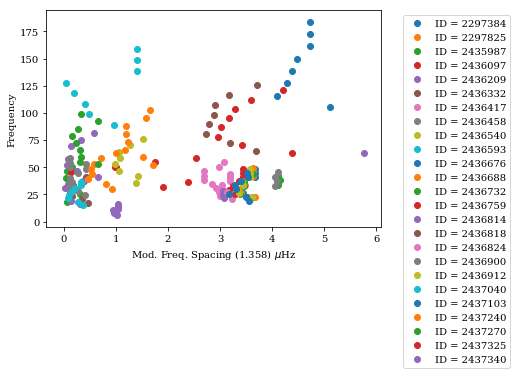

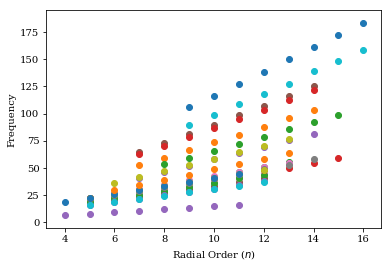

In [5]:
%matplotlib inline
plt.figure(1)
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
#plt.savefig('seminar/manyrgbs.pdf')

plt.figure(2)
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))
plt.xlabel('Radial Order ($n$)')
plt.ylabel('Frequency')
plt.show()

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Resample for model that includes the decay term
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Read in best starting parameters, then find indexes of any stars
# that have unphysical/outlying values. Use these indexes to remove,
# from arrays and data that are parsed into stan for the full run.
no_tau = pd.read_csv('../data/stanfits/ngc6791_notau.csv', names=['kic', 'dnu', 'numax',
					 'epsilon', 'alpha', 'A', 'G', 'phi', 'tau'])
idxs = no_tau[(no_tau['A']<0.0) | (no_tau['A']>0.1) |
              (no_tau['alpha']<0.0)| (no_tau['epsilon']>0.35)].index
#print(arr_n)
#print(idxs.values)
arr_n2 = np.delete(arr_n, [idxs], axis=0)
arr_freq2 = np.delete(arr_freq, [idxs], axis=0)
arr_freqerr2 = np.delete(arr_freqerr, [idxs], axis=0)
Numax2 = np.delete(Numax, [idxs], axis=0)
Numax_err2 = np.delete(Numax_err, [idxs], axis=0)
dnu_avgarr2 = np.delete(dnu_avgarr, [idxs], axis=0)

no_tau = no_tau.drop(no_tau.index[[idxs]])
display(no_tau)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  from ipykernel import kernelapp as app
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/usr/lib/python

,kic,dnu,numax,epsilon,alpha,A,G,phi,tau
10,2436732.0,3.655494,30.025531,-0.082445,0.019349,0.000591,2.391719,-2.552552,NaN
21,2570518.0,4.916113,45.612140,0.094794,0.017047,0.024006,2.142277,0.813236,NaN
25,2437781.0,7.802141,84.065793,0.205895,0.013120,0.000775,2.848690,-0.010329,NaN
40,2437394.0,12.956046,161.129930,0.277767,0.013530,0.000760,2.889610,0.281898,NaN
51,2570518.0,4.912026,45.362070,0.102491,0.017102,0.003908,2.051352,1.758412,NaN
54,2438051.0,3.664735,30.304368,-0.097694,0.023483,0.006635,2.494725,-0.641419,NaN
55,2436818.0,8.717997,94.280834,0.285199,0.016716,0.011505,3.514101,1.904045,NaN
58,2437270.0,6.495155,69.396707,0.126632,0.010262,0.005827,3.262293,0.076180,NaN


In [7]:
code = '''
functions {
    real glitch(real n, real dnu, real numax, real epsilon, real alpha, real A, real G, real phi, real tau){
        real nmax = numax/dnu - epsilon;
        return (n + epsilon + alpha/2 * (n-nmax)^2 + 
                (A*G)/(2*pi()) * sin((2*pi()*(n-nmax))/G + phi) * exp(-(n-nmax)/tau)) * dnu;
    }
}

data {
    int N;                  //number of stars
    int M;                  //number of modes
    real n[N, M];           //radial mode number
    real freq[N, M];        //l=0 frequencies
    real freq_err[N, M];
    real numax_obs[N];
    real numax_err[N];
    real dnu_guess[N];
}

parameters {
    // Normal Parameters
    real dnu[N];
    real numax[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real G[N];
    real<lower = 0.0001> tau[N];
    
    
    // Hierarchical Parameters
    real eps_std[N];
    real<lower=0> eps_sig;
    real epsA;
    real epsB;
    
    real al_std[N];
    real<lower=0> al_sig;
    real alA;
    real alB;
    
    real A_std[N];
    real<lower=0> A_sig;
    real AA;
    real AB;
    
    //real G_std[N];
    //real<lower=0> G_sig;
    //real GA;
    
}

transformed parameters {
    real epsilon[N];
    real alpha[N];
    real A[N];
    //real G[N];
    
    for (i in 1:N){
        epsilon[i] = eps_std[i] * eps_sig + (epsA + epsB * log(dnu[i]));
        alpha[i] = al_std[i] * al_sig + (alA * (dnu[i])^(-alB));
        A[i] = A_std[i] * A_sig + (AA * (dnu[i])^(-AB));
        //G[i] = G_std[i] * G_sig + GA;
    }
}

model {
    real mod[M];
    for (i in 1:N){
        for (j in 1:M){
            mod[j] = glitch(n[i,j], dnu[i], numax[i], epsilon[i], alpha[i], A[i], G[i], phi[i], tau[i]);
        }
        freq[i,:] ~ normal(mod, freq_err[i,:]);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.01);
        numax[i] ~ normal(numax_obs[i], numax_err[i]);
    }
    
	//epsilon ~ uniform(0.001, 1.5);
	A ~ uniform(0, 0.1);
    G ~ normal(3.08, 0.65);  
    //numax ~ normal(numax_obs, numax_err);
    tau ~ normal(10, 4);
    
    // Hierarchical Parameters
    eps_std ~ normal(0, 1);
    eps_sig ~ normal(0, 0.5);
    epsA ~ normal(0.601, 0.25);
    epsB ~ normal(0.632, 0.25);
    
    al_std ~ normal(0, 1);
    al_sig ~ normal(0, 0.5);    
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    
    A_std ~ student_t(8, 0, 1);
    A_sig ~ normal(0, 0.5);
    AA ~ normal(0.06, 0.02);
    AB ~ normal(0.88, 0.05);
    
    //G_std ~ normal(0, 1);
    //G_sig ~ normal(0.65, 0.5);
    //GA ~ normal(3.08, 0.1);
}
'''
sm2 = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb7b51709db47c6695c51152f170a4b8 NOW.


In [8]:
stan_data = {'N': len(no_tau['kic']),
         'M': maxmodes,
         'n': arr_n2, 
         'freq': arr_freq2,
         'freq_err': arr_freqerr2,
         'numax_obs': Numax2,
         'numax_err': Numax_err2,
         'dnu_guess': dnu_avgarr2
        }
start = {'dnu': dnu_avgarr2,
         'numax': Numax2,
         'eps_sig': 0.01,
         'al_sig': 0.01,
         'A_sig': 0.0001,
         #'G_sig': 0.65,
         'epsilon': no_tau['epsilon'],
         'alpha': no_tau['alpha'],
         'A': no_tau['A'],
         'G': no_tau['G'],
         'phi': no_tau['phi'],
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         'AA': 0.07,
         'AB': 0.87,
         #'GA': 3.08
         'tau': np.ones([len(no_tau['kic'])])*10
    }
nchains = 4

fit2 = sm2.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])  


RuntimeError: Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=n; position=0; dims declared=(8,8); dims found=(2,8)  (in 'unknown file name' at line 13)


In [ ]:
summ_tau = fit2.stansummary(digits_summary = 3)

fit_2 = np.zeros([len(no_tau['kic']), 9])

for i in np.arange(0,len(no_tau['kic']),1):
	fit_2[i] = [no_tau['kic'].iloc[i],
				np.mean(fit2['dnu'], axis=0)[i],
				np.mean(fit2['numax'], axis=0)[i],
				np.mean(fit2['epsilon'], axis=0)[i],
				np.mean(fit2['alpha'], axis=0)[i],
				np.mean(fit2['A'], axis=0)[i],
				np.mean(fit2['G'], axis=0)[i],
				np.mean(fit2['phi'], axis=0)[i],
				np.mean(fit2['tau'], axis=0)[i]]
    
print(np.mean(fit2['AA']))

#print(fit_2[:,0].astype(int))
#print(summ_tau)

In [21]:
np.savetxt('ngc6791_tau.csv', fit_2, delimiter=',')
with open('ngc6791_summ_tau.txt', 'w') as f:
		f.write(summ_tau)

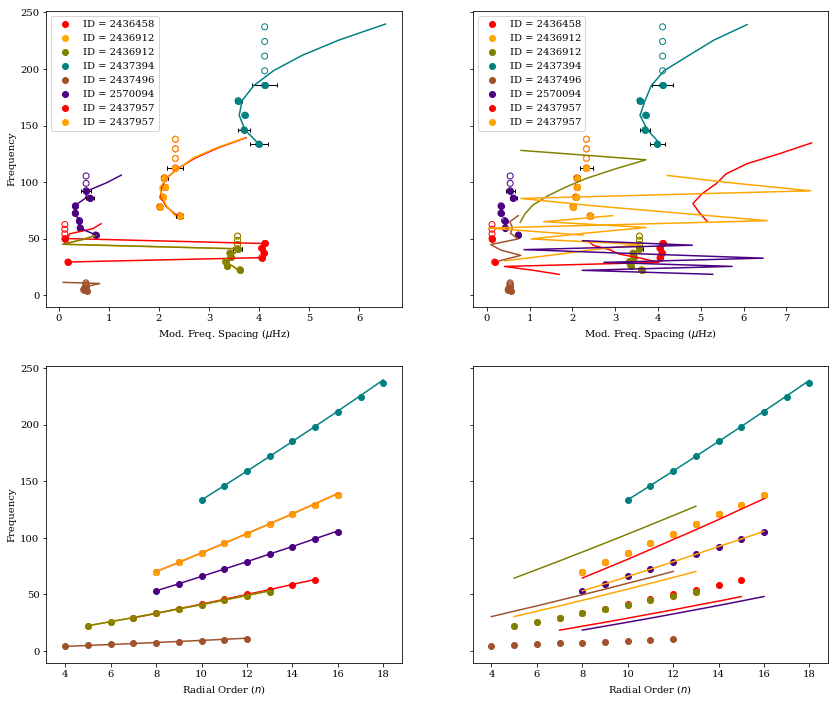

In [24]:
#%matplotlib inline
def notau(n,dnu,numax,eps,alpha,A,G,phi):
    nmax = numax/dnu - eps
    s = (n + eps + ((alpha/2)*(nmax-n)**2) +
         (((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi)))*dnu
    return s
def model(n,dnu,numax,eps,alpha,A,G,phi,tau):
    nmax = numax/dnu - eps
    s = (n + eps + (alpha/2)*(nmax-n)**2 +
         ((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi)*np.exp(-(n-nmax)/(tau)))*dnu
    return s

fit_1 = np.loadtxt('../data/stanfits/ngc6791_notau.csv', delimiter=',')
#fit_2 = np.loadtxt('ngc6791_tau.csv', delimiter=',')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,12), sharey=True)
#ax  = fig.add_subplot(111)
#ax.set_position([0.1,0.1,0.6,0.85])

import itertools
colours = itertools.cycle(('r', 'orange', 'olive', 'teal', 'sienna', 'indigo'))

for i in np.arange(0,len(no_tau['kic']),1):
    # Iterate point colour
    colour = next(colours)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    ### FITS SANS TAU ###
    ax1.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    ax1.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    ax1.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)
    
    g1 = notau(arr_n[i], fit_1[i,1], fit_1[i,2], fit_1[i,3], fit_1[i,4],
               fit_1[i,5], fit_1[i,6], fit_1[i,7])
    ax1.plot(g1 % dnu_avgID[i], g1, c=colour)
    ### FITS WITH TAU ###
    ax2.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    ax2.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    ax2.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)
    
    g2 = model(arr_n2[i], fit_2[i,1], fit_2[i,2], fit_2[i,3], fit_2[i,4],
               fit_2[i,5], fit_2[i,6], fit_2[i,7], 100000)
    ax2.plot(g2 % dnu_avgID[i], g2, c=colour)
    
    ax3.scatter(modesID[i]['n'], modesID[i]['f0'], label=r'ID = '+str(IDs[i]), c=colour)
    ax3.plot(modesID[i]['n'], g1, c=colour, label=r'ID = '+str(IDs[i]))
    ax4.scatter(modesID[i]['n'], modesID[i]['f0'], label=r'ID = '+str(IDs[i]), c=colour)
    ax4.plot(modesID[i]['n'], g2, c=colour, label=r'ID = '+str(IDs[i]))


ax1.legend()
ax2.legend()
ax1.set_ylabel('Frequency')
ax1.set_xlabel(r'Mod. Freq. Spacing ($\mu$Hz)')
ax2.set_xlabel(r'Mod. Freq. Spacing ($\mu$Hz)')
ax3.set_xlabel('Radial Order ($n$)')
ax4.set_xlabel('Radial Order ($n$)')
ax3.set_ylabel('Frequency')
plt.show()

In [12]:
tau = pd.read_csv('ngc6791_tau.csv', names=['kic', 'dnu', 'numax',
					 'epsilon', 'alpha', 'A', 'G', 'phi', 'tau'])
display(no_tau)
display(tau)

,kic,dnu,numax,epsilon,alpha,A,G,phi,tau
10,2436732.0,3.655494,30.025531,-0.082445,0.019349,0.000591,2.391719,-2.552552,NaN
21,2570518.0,4.916113,45.612140,0.094794,0.017047,0.024006,2.142277,0.813236,NaN
25,2437781.0,7.802141,84.065793,0.205895,0.013120,0.000775,2.848690,-0.010329,NaN
40,2437394.0,12.956046,161.129930,0.277767,0.013530,0.000760,2.889610,0.281898,NaN
51,2570518.0,4.912026,45.362070,0.102491,0.017102,0.003908,2.051352,1.758412,NaN
54,2438051.0,3.664735,30.304368,-0.097694,0.023483,0.006635,2.494725,-0.641419,NaN
55,2436818.0,8.717997,94.280834,0.285199,0.016716,0.011505,3.514101,1.904045,NaN
58,2437270.0,6.495155,69.396707,0.126632,0.010262,0.005827,3.262293,0.076180,NaN


,kic,dnu,numax,epsilon,alpha,A,G,phi,tau
0,2436732.0,3.652844,29.742924,-0.075049,0.019244,0.024967,2.338887,-4.225508,12.089714
1,2570518.0,4.912473,45.543351,0.102048,0.016875,0.028939,2.400632,0.980678,6.353486
2,2437781.0,7.805380,84.239788,0.201747,0.013487,0.003647,2.881189,-0.196245,10.342130
3,2437394.0,12.943482,161.335586,0.291386,0.011755,0.005550,2.875643,0.102962,10.297460
4,2570518.0,4.911499,45.474616,0.103892,0.016876,0.028455,2.441794,0.789674,6.332590
5,2438051.0,3.661487,30.295118,-0.085792,0.020201,0.013705,3.270376,1.084009,9.368374
6,2436818.0,8.742763,96.093201,0.256226,0.015072,-0.000195,3.479968,2.970975,9.572364
7,2437270.0,6.499883,70.566655,0.118000,0.012177,0.018401,3.180367,0.779397,10.617508


In [58]:
for i in range(len(no_tau['kic'])):
    print(no_tau['kic'].iloc[i])

2436732.0
2570518.0
2437781.0
2437394.0
2570518.0
2438051.0
2436818.0
2437270.0


In [73]:
filename = 'ngc6791_%s' % int(nstars) +'.csv'
print(filename)

ngc6791_25.csv
